In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (10, 5)})

In [3]:
# Load main datasets
lol_df = pd.read_csv("lol.csv")
wow_df = pd.read_csv("wow.csv")

# Load annotation files
lol_ann = pd.read_csv("lol_annotations.csv")
wow_ann = pd.read_csv("wow_annotations.csv")

# Keep only first 2 columns (keys for joining)
lol_ann_keys = lol_ann.iloc[:, :2]
wow_ann_keys = wow_ann.iloc[:, :2]

In [4]:
# Label LOL dataset
lol_df["class"] = "Non-Hate"
lol_df.loc[
    lol_df.set_index(lol_ann_keys.columns.tolist()).index.isin(
        lol_ann_keys.set_index(lol_ann_keys.columns.tolist()).index
    ),
    "class"
] = "Hate"

# Label WOW dataset
wow_df["class"] = "Non-Hate"
wow_df.loc[
    wow_df.set_index(wow_ann_keys.columns.tolist()).index.isin(
        wow_ann_keys.set_index(wow_ann_keys.columns.tolist()).index
    ),
    "class"
] = "Hate"

# Concatenate datasets
df = pd.concat([lol_df, wow_df], ignore_index=True)

print("Final dataset shape:", df.shape)
print(df["class"].value_counts())


Final dataset shape: (34329, 6)
Non-Hate    33915
Hate          414
Name: class, dtype: int64


In [6]:
# Assuming column with timestamp is named "created_at"
# Adjust name if different
df["created_at"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

# Extract year-month for grouping
df["month"] = df["created_at"].dt.to_period("M")

print("Date range:", df["created_at"].min(), "→", df["created_at"].max())


Date range: 2011-02-22 15:28:00+00:00 → 2015-06-09 10:22:02+00:00


c:\Users\Dario\miniconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


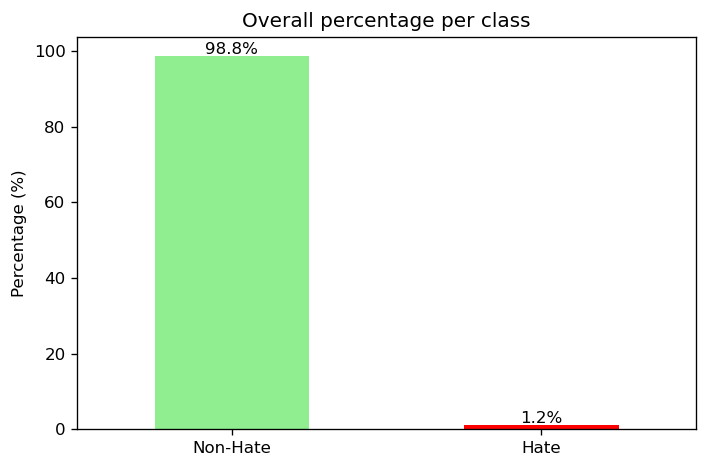

In [7]:
colors = {"Hate": "red", "Non-Hate": "lightgreen"}
class_percent = df["class"].value_counts(normalize=True).reindex(["Non-Hate", "Hate"]).fillna(0) * 100

plt.figure(figsize=(6,4))
class_percent.plot(kind="bar", color=[colors[c] for c in class_percent.index])
plt.title("Overall percentage per class")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
for i, v in enumerate(class_percent):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center")
plt.tight_layout()
plt.show()


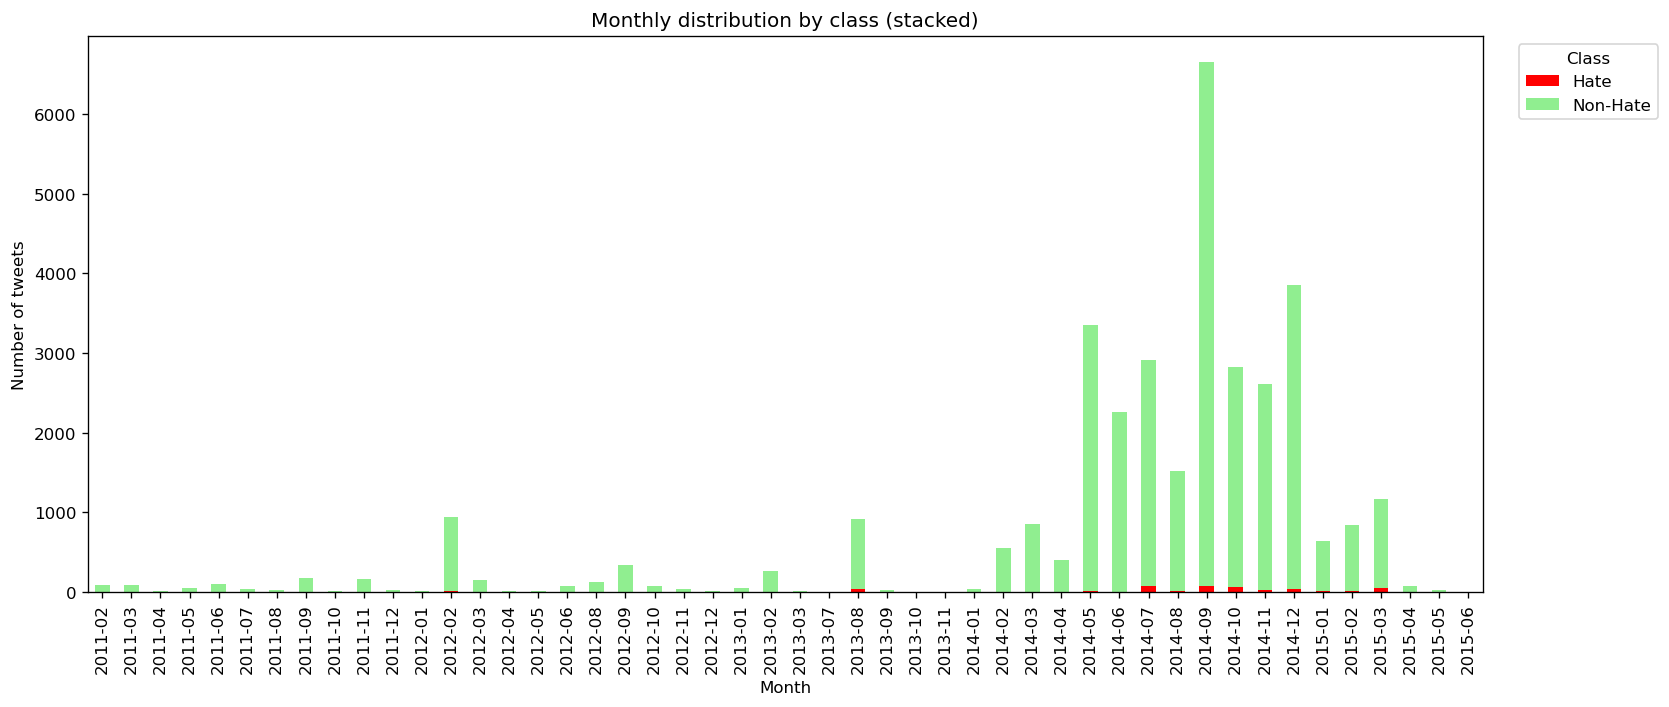

In [8]:
monthly_counts = df.groupby(["month", "class"]).size().unstack(fill_value=0)

monthly_counts.plot(kind="bar", stacked=True, figsize=(14,6), color=[colors.get(c) for c in monthly_counts.columns])
plt.title("Monthly distribution by class (stacked)")
plt.xlabel("Month")
plt.ylabel("Number of tweets")
plt.xticks(rotation=90)
plt.legend(title="Class", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


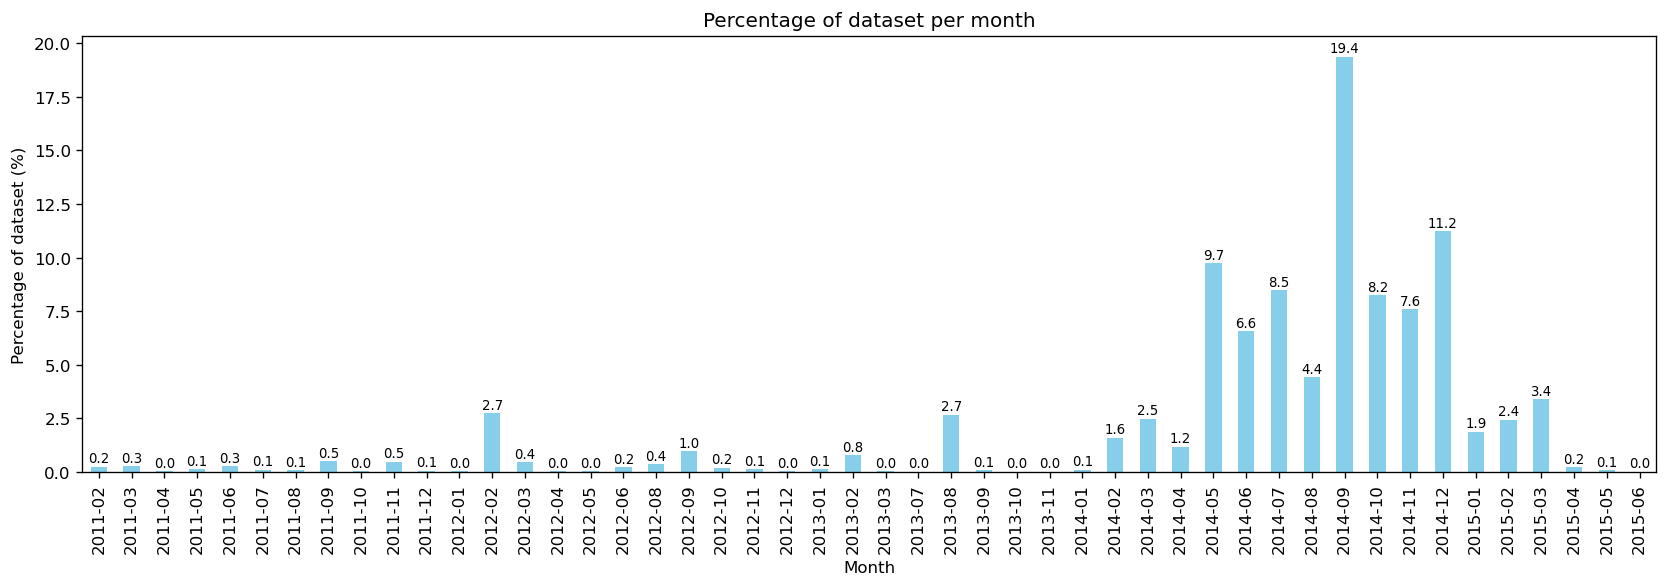

In [17]:
# % of dataset per month (ignoring class)
month_total_percent = monthly_counts.sum(axis=1) / len(df) * 100

plt.figure(figsize=(14,5))
month_total_percent.plot(kind="bar", color="skyblue")
plt.title("Percentage of dataset per month")
plt.xlabel("Month")
plt.ylabel("Percentage of dataset (%)")
plt.xticks(rotation=90)
for i, v in enumerate(month_total_percent):
    plt.text(i, v + 0.2, f"{v:.1f}", ha="center", fontsize=8)
plt.tight_layout()
plt.show()


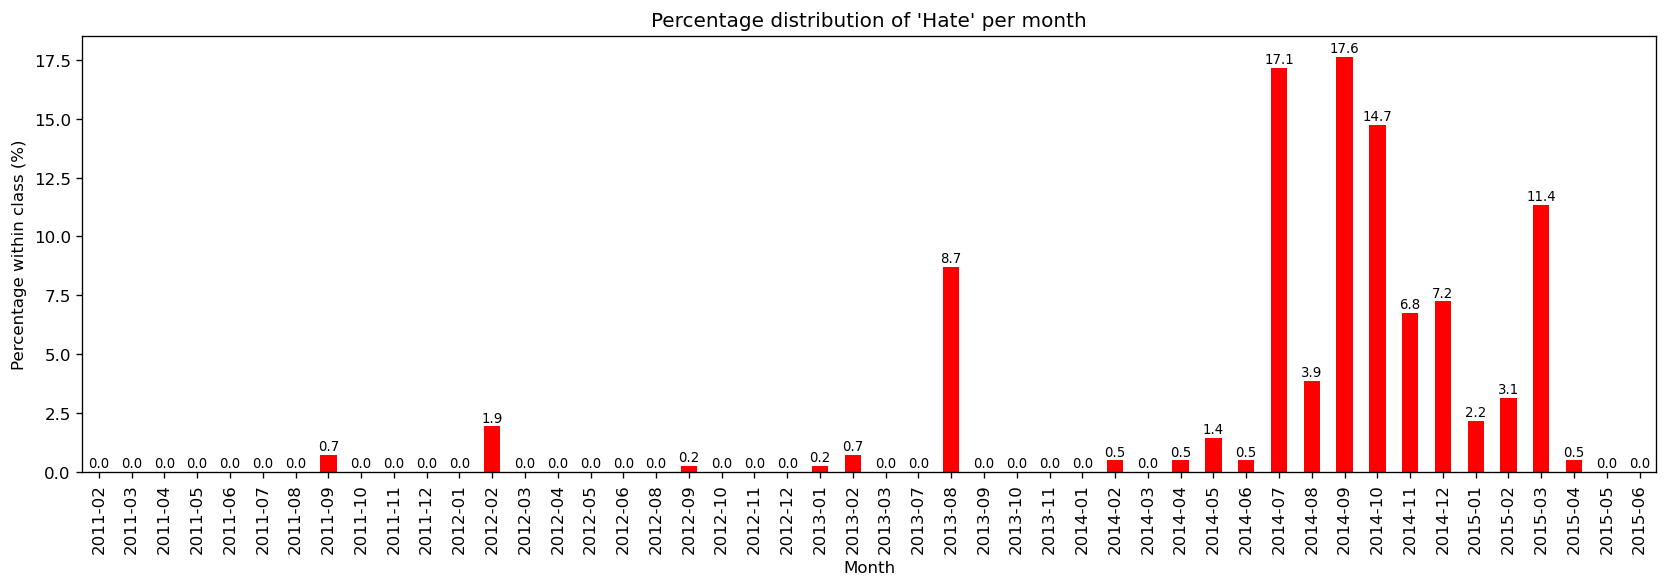

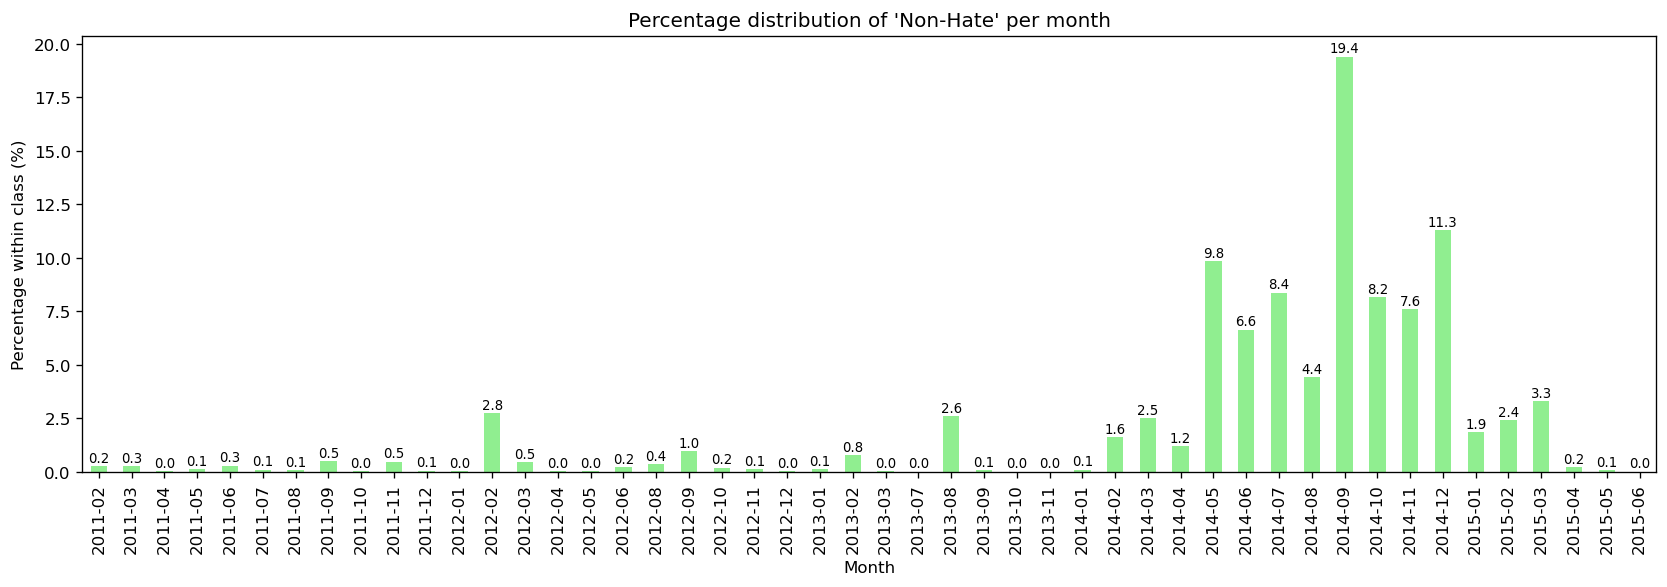

In [16]:
# % of class per month (relative to that class total)
class_month_percent = monthly_counts.div(monthly_counts.sum(axis=0), axis=1) * 100

# One chart per class
for col in class_month_percent.columns:
    plt.figure(figsize=(14,5))
    class_month_percent[col].plot(kind="bar", color=colors.get(col, "gray"))
    plt.title(f"Percentage distribution of '{col}' per month")
    plt.xlabel("Month")
    plt.ylabel("Percentage within class (%)")
    plt.xticks(rotation=90)
    
    # Add percentage labels
    for i, v in enumerate(class_month_percent[col]):
        plt.text(i, v + 0.2, f"{v:.1f}", ha="center", fontsize=8)
    
    plt.tight_layout()
    plt.show()
